In [1]:
from os import listdir
from os.path import isfile, join
import sys
sys.path.append("/Users/andyreagan/tools/python")
from kitchentable.dogtoys import *
from json import loads
from re import findall,UNICODE
from labMTsimple.labMTsimple.speedy import LabMT
my_LabMT = LabMT()
from labMTsimple.labMTsimple.storyLab import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from database.bookclass import Book_raw_data
import pickle

import os
sys.path.append('/Users/andyreagan/projects/2014/09-books/database')
os.environ.setdefault('DJANGO_SETTINGS_MODULE','gutenbergdb.settings')
import django
django.setup()

from library.models import *

from datetime import datetime

In [2]:
# all our essentials
from matplotlib import rc,rcParams
# rc('font', family='sans-serif') 
# rc('font', serif='Helvetica Neue')
# rc('text', usetex='false') 

rc('font', family='serif')
rc('font', family='cmr10')
rc('text', usetex='false') 

rcParams.update({'font.size': 12})
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
q = Book.objects.filter(exclude=False,
                        length__gt=10000,
                        length__lte=200000,
                        downloads__gte=150,
                        numUniqWords__gt=1000,
                        numUniqWords__lt=18000,
                        lang_code_id=0).order_by("gutenberg_id")

In [4]:
use_cache = True
version = "006"
if isfile("data/gutenberg/timeseries-matrix-cache-{}.p".format(version)) and use_cache:
    big_matrix = pickle.load(open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"rb"))
else:
    # load all of the timeseries into a matrix
    big_matrix = np.ones([len(q),200])
    # big_matrix_mean0 = np.ones(big_matrix.shape)
    stop_val = 1.0
    for i,b in enumerate(q):
        if i%100 == 0:
            print(i)
        # print(b.title)
        b_data = Book_raw_data(b)
        a = b_data.chopper_sliding(my_LabMT,num_points=200,stop_val=stop_val)
        big_matrix[i,:] = b_data.timeseries
    print(big_matrix.shape)
    pickle.dump(big_matrix,open("data/gutenberg/timeseries-matrix-cache-{}.p".format(version),"wb"),pickle.HIGHEST_PROTOCOL)
    
big_matrix_mean0 = big_matrix-np.tile(big_matrix.mean(axis=1),(200,1)).transpose()
big_matrix_start0 = big_matrix-np.tile(big_matrix[:,0],(200,1)).transpose()
print(big_matrix.shape)

(1729, 200)


In [5]:
def cityBlock(a,b):
    return np.sum(np.abs(a-b))

In [6]:
# define a quick cache for this one...
if isfile("data/gutenberg/pairwise-distance-matrix-cache.p") and use_cache:
    allDistances = pickle.load(open("data/gutenberg/pairwise-distance-matrix-cache.p","rb"))
    allDistancesCentered = pickle.load(open("data/gutenberg/pairwise-distance-mean0-matrix-cache.p","rb"))
    allDistancesStart = pickle.load(open("data/gutenberg/pairwise-distance-start0-matrix-cache.p","rb"))
else:
    pairWiseDistances = np.zeros([big_matrix.shape[0],big_matrix.shape[0]])
    pairWiseDistancesCentered = np.zeros([big_matrix_mean0.shape[0],big_matrix_mean0.shape[0]])
    pairWiseDistancesStart = np.zeros([big_matrix_start0.shape[0],big_matrix_start0.shape[0]])
    for i in range(big_matrix.shape[0]):
        if i%100 == 0:
            print(i)
        # compute only the upper diagonal
        for j in range(i,big_matrix.shape[0]):
            pairWiseDistances[i,j] = cityBlock(big_matrix[i,:],big_matrix[j,:])
            pairWiseDistancesCentered[i,j] = cityBlock(big_matrix_mean0[i,:],big_matrix_mean0[j,:])
            pairWiseDistancesStart[i,j] = cityBlock(big_matrix_start0[i,:],big_matrix_start0[j,:])
    # build the full matrices
    allDistances = pairWiseDistances+np.transpose(pairWiseDistances)
    allDistancesCentered = pairWiseDistancesCentered+np.transpose(pairWiseDistancesCentered)
    allDistancesStart = pairWiseDistancesStart+np.transpose(pairWiseDistancesStart)
    pickle.dump(allDistances,open("data/gutenberg/pairwise-distance-matrix-cache.p","wb"),pickle.HIGHEST_PROTOCOL)
    pickle.dump(allDistancesCentered,open("data/gutenberg/pairwise-distance-mean0-matrix-cache.p","wb"),pickle.HIGHEST_PROTOCOL)
    pickle.dump(allDistancesStart,open("data/gutenberg/pairwise-distance-start0-matrix-cache.p","wb"),pickle.HIGHEST_PROTOCOL)

In [7]:
def distanceFun(i,shape):
    x = np.abs(np.arange(shape)-i)
    # this index doesn't matter!
    x[i] = 1.
    x = 1./x
    return x

In [8]:
def costFun(distanceMatrix):
    # the cost starts at 0
    c = 0
    # loop over rows, and sum up the cost
    for i in range(distanceMatrix.shape[0]):
        c += np.dot(distanceMatrix[i,:],distanceFun(i,distanceMatrix.shape[1]))
    return c

In [9]:
def costFun2(distanceMatrix):
    # the cost starts at 0
    c = 0
    # loop over rows, and sum up the cost
    for i in range(distanceMatrix.shape[0]):
        c += np.dot(distanceMatrix[i,:],np.arange(distanceMatrix.shape[1])-i)
    return c

In [10]:
    def costFun3(distanceMatrix,weightMatrix):
        return np.sum(np.multiply(distanceMatrix,weightMatrix),axis=(0,1))

In [11]:
# this is less multiplying and adding, but it's slower
def costFun4(distanceMatrix,weightMatrix):
    return np.sum(np.multiply(np.triu(distanceMatrix,k=1),np.triu(weightMatrix,k=1)),axis=(0,1))

In [12]:
def costFun5(distanceMatrix,weightMatrix,i,swap,oldcost):
    # compute the dot products for the old columns
    oldcol = np.dot(distanceMatrix[:,i],weightMatrix[:,i])+np.dot(distanceMatrix[:,swap],weightMatrix[:,swap])
    # compute the dot products for the old rows
    oldrow = np.dot(distanceMatrix[i,:],weightMatrix[i,:])+np.dot(distanceMatrix[swap,:],weightMatrix[swap,:])
    # compute the dot products for the new columns
    newcol = np.dot(distanceMatrix[:,swap],weightMatrix[:,i])+np.dot(distanceMatrix[:,i],weightMatrix[:,swap])
    # compute the dot products for the new rows
    newrow = np.dot(distanceMatrix[swap,:],weightMatrix[i,:])+np.dot(distanceMatrix[i,:],weightMatrix[swap,:])
    return oldcost-oldcol-oldrow+newcol+newrow

In [13]:
def reshaper(newShape,matrix):
    newMatrix = np.zeros(matrix.shape)
    for i in range(matrix.shape[0]):
        newMatrix[i,:] = matrix[i,newShape]
    newMatrix = newMatrix[newShape,:]
    return newMatrix

In [14]:
def computeBestSwap(distanceMatrix,n,i,weightMatrix,oldcost,v=False):
    maxDistanceReduction = 0
    bestSwap = 0
    if n < distanceMatrix.shape[0]:
        iterList = np.random.randint(0,high=distanceMatrix.shape[0],size=n)
    else:
        iterList = range(distanceMatrix.shape[0])
    for swap in iterList:
        # a = np.arange(distanceMatrix.shape[0])
        # a[[i,swap]] = [swap,i]
        # tmpswapped = distanceMatrix[a,a]
        # b = np.sum(np.multiply(distanceMatrix[np.ix_(a,a)],weightMatrix),axis=(0,1))
        # b = costFun3(distanceMatrix[np.ix_(a,a)],weightMatrix)
        b = costFun5(distanceMatrix,weightMatrix,i,swap,oldcost)
        if oldcost-b > maxDistanceReduction:
            # print("found a swap that reduces distance to: {0}".format(b))
            maxDistanceReduction = oldcost-b
            bestSwap = swap
    if v:
        print("best swap: distance\tnode")
        print("           {0:.3f}\t{1}".format(maxDistanceReduction,bestSwap))

    return (maxDistanceReduction,bestSwap)

In [15]:
def runSortingAlgorithm(sortedDistances,exponent=-.5,niter=0,v=False,plot_every=0):
    weightMatrix = np.zeros(sortedDistances.shape)
    for i in range(weightMatrix.shape[0]):
        weightMatrix[i,:] = np.abs(np.arange(weightMatrix.shape[1])-i)
        # this index doesn't matter! (but set it to 1 so power doesn't complain)
        weightMatrix[i,i] = 1.
        weightMatrix[i,:] = np.power(weightMatrix[i,:],exponent)

    sortedIndex = np.arange(sortedDistances.shape[0])
    if niter == 0:
        niter = sortedDistances.shape[0]
    # niter = 10
    n = sortedDistances.shape[0]
    # n = np.floor(np.sqrt(sortedDistances.shape[0]))
    # n = 10
    allcost = np.zeros(niter+1)
    allcost[0] = costFun3(sortedDistances,weightMatrix)
    if v:
        print("initial cost: {0:.2f}".format(allcost[0]))
    for i in range(niter):
        # so we can run more iterations than the number of books
        node = np.mod(i,sortedDistances.shape[0])
        if v:
            print("iteration {0}, node {1}".format(i,node))
        # find the best swap
        maxD,bswap = computeBestSwap(sortedDistances,n,node,weightMatrix,allcost[i],v=v)
        # make that swap
        if maxD > 0:
            if v:
                print("swapping")
            a = np.arange(sortedDistances.shape[0])
            a[[node,bswap]] = [bswap,node]
            sortedIndex[[node,bswap]] = sortedIndex[[bswap,node]]
            sortedDistances = sortedDistances[np.ix_(a,a)]
            # save the next cost function
            allcost[i+1] = np.sum(np.multiply(sortedDistances,weightMatrix),axis=(0,1))
        else:
            if v:
                print("no better position found, not swapping")
            allcost[i+1] = allcost[i]
        if v:
            print("new cost: {0:.2f}".format(allcost[i+1]))
        if plot_every > 0:
            if i%plot_every == 0:
                plotDistanceMatrix(allDistancesCentered,sortedDistances,suffix=i,cap=50)
        
    if v:
        print("saving to a file...")
    now = datetime.now()
    formatted_fname = now.strftime("data/gutenberg/%Y-%m-%d-%H-%M-allDistances-cityblock-sorted.p")
    pickle.dump(sortedDistances,open(formatted_fname,"wb"),pickle.HIGHEST_PROTOCOL)
    formatted_fname = now.strftime("data/gutenberg/%Y-%m-%d-%H-%M-cost-cityblock-sorted.p")
    pickle.dump(allcost,open(formatted_fname,"wb"),pickle.HIGHEST_PROTOCOL)
    
    return sortedDistances,allcost

In [16]:
def plotDistanceMatrix(data,data_sorted,suffix='',useclim=True,cap=120,figsize=30,cmap="magma"):
    numel = len(q)-1

    fig = plt.figure(figsize=(22.5,7.5))
    ax1 = fig.add_axes([0.15,0.15,0.8/3,0.8-.04])
    # screw memory...I have a SSD!
    # plt.subplot(1,2,1)
    data_capped = data.copy()
    data_capped[data > cap] = cap
    ax1.imshow(data_capped,cmap=plt.get_cmap(cmap))
    # # ax1.colorbar()
    # # plt.colorbar(cax,shrink=0.8)
    # # plt.clim([0,120])
    # plt.title('unsorted distance matrix')
    ax1.set_xlabel('Book ID')
    # plt.ylabel('book num')

    data_sorted_capped = data_sorted.copy()
    data_sorted_capped[data_sorted > cap] = cap
    ax2 = fig.add_axes([0.15+0.8/3,0.15,0.8/3,0.8-.04])
    ax2.imshow(data_sorted_capped,cmap=plt.get_cmap(cmap))
    # # ax1.colorbar()
    # # plt.colorbar(cax,shrink=0.8)
    # # plt.clim([0,120])
    # plt.title('unsorted distance matrix')
    ax2.set_xlabel('Book ID')
    ax2.set_yticklabels([])

    # go and find the shift! put the story with the greatest distance between neighbors in the
    # upper left
    shift = list(map(lambda x: x%len(q),np.arange(data_sorted.shape[0])+np.argmax(data_sorted.sum(axis=1))))
    ax3 = fig.add_axes([0.15+0.8/3+0.8/3,0.15,0.8/3,0.8-.04])
    ax3.imshow(data_sorted_capped[shift,:][:,shift],cmap=plt.get_cmap(cmap))
    # # ax1.colorbar()
    # # plt.colorbar(cax,shrink=0.8)
    # # plt.clim([0,120])
    # plt.title('unsorted distance matrix')
    ax3.set_xlabel('Book ID')
    ax3.set_yticklabels([])

    ax4 = fig.add_axes([0.15+0.8/3+0.8/3+0.8/3,0.15,0.03,0.8-.04])
    my_cmap = np.tile(np.arange(data.shape[0]),(100,1)).transpose()
    print(my_cmap)
    ax4.imshow(my_cmap,cmap=plt.get_cmap(cmap),origin="lower")
    ax4.set_xticks([])
    ax4.set_xticklabels([])
    ax4.yaxis.tick_right()
    ax4.set_yticks([0,numel*.25,numel*.5,numel*.75,numel])
    ax4.set_yticklabels(map(int,[0,cap*.25,cap*.5,cap*.75,cap]))

    mysavefig("sorted-matrix-{}-{}.pdf".format(cap,suffix),openfig=True,date=True,folder="media/figures/ring-sort")

In [17]:
def plotCostFunction(data,suffix=''):
    fig = plt.figure(figsize=(7,7))
    ax1 = fig.add_axes([0.2,0.2,0.7,0.7])
    plt.plot(data)
    ax1.set_title('')
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('cost')
    
    mysavefig('cost-decay{0}.pdf'.format(suffix),folder="media/figures/ring-sort")

In [18]:
def testSortingAlgorithm():
    # first test, generate a gaussian of distances
    nsamples = 500
    samples = np.random.rand(nsamples,1)
    np.random.shuffle(samples)

    # plt.hist(samples)
    # plt.show()
    # plt.close()

    pairWiseDistances = np.zeros([samples.shape[0],samples.shape[0]])
    for i in range(samples.shape[0]):
        for j in range(i,samples.shape[0]):
            dis = np.abs(samples[i]-samples[j])
            # do it on a ring!
            pairWiseDistances[i,j] = np.min([dis,1-dis])

    allDistances = pairWiseDistances+np.transpose(pairWiseDistances)

    outputSuffix='test-{0}-1'.format(nsamples)
    f = open('pairwiseDistanceCityblockUnsorted{0}.csv'.format(outputSuffix),'w')
    csvwriter = csv.writer(f)
    for i in range(allDistances.shape[0]):
        csvwriter.writerow(allDistances[i,:])
    f.close()
    # plotDistanceMatrix(allDistances,suffix='-unsorted',useclim=False)

    runSortingAlgorithm(allDistances,outputSuffix=outputSuffix,exponent=-0.5)

    fname = 'pairwiseDistanceCityblockSorted{0}.csv'.format(outputSuffix)
    data = np.genfromtxt(fname,dtype=float,delimiter=',')
    plotDistanceMatrix(data,suffix='-sorted',useclim=False)


    # # first test, generate a gaussian of distances
    # samples = np.concatenate((np.random.normal(loc=-3.0,size=125),np.random.normal(loc=3.0,size=125)))

    # np.random.shuffle(samples)

    # plt.close()
    # plt.clf()
    # plt.hist(samples)
    # plt.show()
    # plt.close()

    # pairWiseDistances = np.zeros([samples.shape[0],samples.shape[0]])
    # for i in range(samples.shape[0]):
    #     for j in range(i,samples.shape[0]):
    #         pairWiseDistances[i,j] = np.abs(samples[i]-samples[j])

    # allDistances = pairWiseDistances+np.transpose(pairWiseDistances)

    # outputSuffix='test-250-2'
    # f = open('pairwiseDistanceCityblockUnsorted{0}.csv'.format(outputSuffix),'w')
    # csvwriter = csv.writer(f)
    # for i in range(allDistances.shape[0]):
    #     csvwriter.writerow(allDistances[i,:])
    # f.close()
    # plotDistanceMatrix(allDistances,suffix='-unsorted-2',useclim=False)

    # runSortingAlgorithm(allDistances,outputSuffix=outputSuffix)

    # fname = 'pairwiseDistanceCityblockSorted{0}.csv'.format(outputSuffix)
    # data = np.genfromtxt(fname,dtype=float,delimiter=',')
    # plotDistanceMatrix(data,suffix='-sorted-2',useclim=False)


    # # first test, generate a gaussian of distances
    # samples = np.concatenate((np.random.normal(loc=-3.0,size=125),np.random.normal(loc=3.0,size=125),np.random.normal(loc=9.0,size=125)))

    # np.random.shuffle(samples)

    # plt.close()
    # plt.clf()
    # plt.hist(samples)
    # plt.show()
    # plt.close()

    # pairWiseDistances = np.zeros([samples.shape[0],samples.shape[0]])
    # for i in range(samples.shape[0]):
    #     for j in range(i,samples.shape[0]):
    #         pairWiseDistances[i,j] = np.abs(samples[i]-samples[j])

    # allDistances = pairWiseDistances+np.transpose(pairWiseDistances)

    # outputSuffix='test-250-3'
    # f = open('pairwiseDistanceCityblockUnsorted{0}.csv'.format(outputSuffix),'w')
    # csvwriter = csv.writer(f)
    # for i in range(allDistances.shape[0]):
    #     csvwriter.writerow(allDistances[i,:])
    # f.close()
    # plotDistanceMatrix(allDistances,suffix='-unsorted-3',useclim=False)

    # runSortingAlgorithm(allDistances,outputSuffix=outputSuffix)

    # fname = 'pairwiseDistanceCityblockSorted{0}.csv'.format(outputSuffix)
    # data = np.genfromtxt(fname,dtype=float,delimiter=',')
    # plotDistanceMatrix(data,suffix='-sorted-3',useclim=False)
    

In [19]:
# testSortingAlgorithm()

# booktimeseries = loadAllTimeseries()
# # save the data for jake
# np.savetxt('sample-timeseries.csv',booktimeseries,delimiter=',',fmt='%.4f')

# data = computeDisMatrix(booktimeseries)
# runSortingAlgorithm(data,outputSuffix='0.25',exponent=-1.0/4)

# print("loading file")
# fname = 'pairwiseDistanceCityblock.csv'
# data = np.genfromtxt(fname,dtype=float,delimiter=',')
# print("running sort")
# runSortingAlgorithm(data,outputSuffix='12000-random')

# fname = 'output/pairwiseDistanceCityblockSorted12000-random.csv'
# data = np.genfromtxt(fname,dtype=float,delimiter=',')
# plotDistanceMatrix(data)

# print("running sort")
# runSortingAlgorithm(data,outputSuffix='15000-random',exponent=-1.0/4)

# fname = 'output/pairwiseDistanceCityblockSorted15000-random.csv'
# data = np.genfromtxt(fname,dtype=float,delimiter=',')
# plotDistanceMatrix(data)

# fname = 'pairwiseDistanceCityblockSorted0.25.csv'
# data = np.genfromtxt(fname,dtype=float,delimiter=',')
# plotDistanceMatrix(data,suffix='0.25')

# fname = 'pairwiseDistanceCityblockSorted0.33.csv'
# data = np.genfromtxt(fname,dtype=float,delimiter=',')
# plotDistanceMatrix(data,suffix='0.33')

# fname = 'pairwiseDistanceCityblockSorted0.5.csv'
# data = np.genfromtxt(fname,dtype=float,delimiter=',')
# plotDistanceMatrix(data,suffix='0.5')

# fname = 'costFunction12000-slowstart.csv'
# data = np.genfromtxt(fname,dtype=float,delimiter=',')
# plotCostFunction(data,suffix="-slowstart")

In [20]:
sortedDistances,cost = runSortingAlgorithm(allDistances,niter=10000)

In [21]:
cost

array([ 7389900.07726039,  7382436.73711574,  7375567.1535102 , ...,
        5703837.25625628,  5703837.25625628,  5703837.25625628])

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1748 1748 1748 ..., 1748 1748 1748]
 [1749 1749 1749 ..., 1749 1749 1749]
 [1750 1750 1750 ..., 1750 1750 1750]]


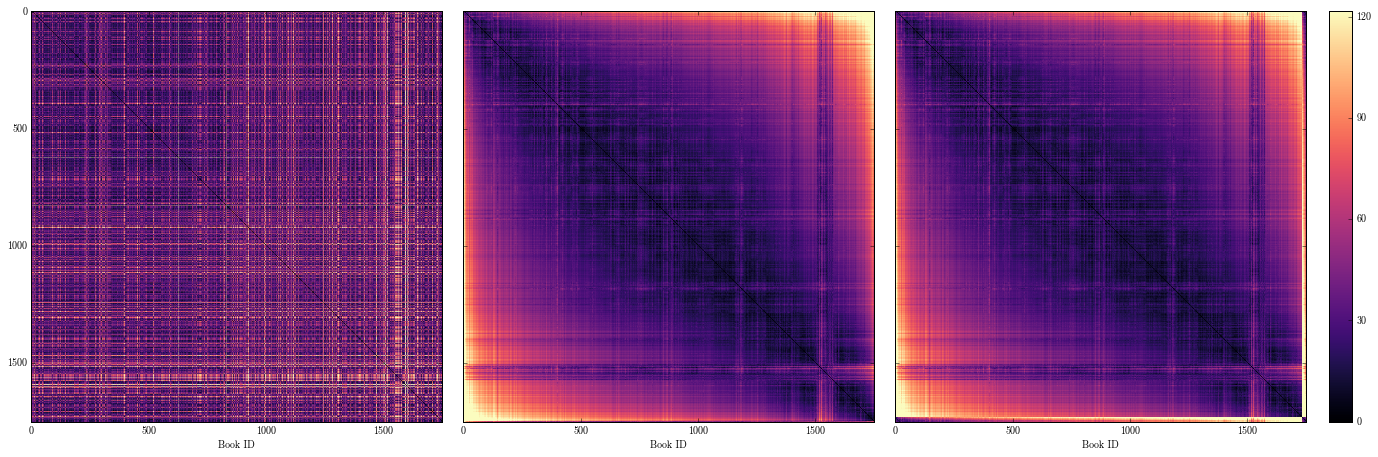

In [22]:
plotDistanceMatrix(allDistances,sortedDistances)

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]


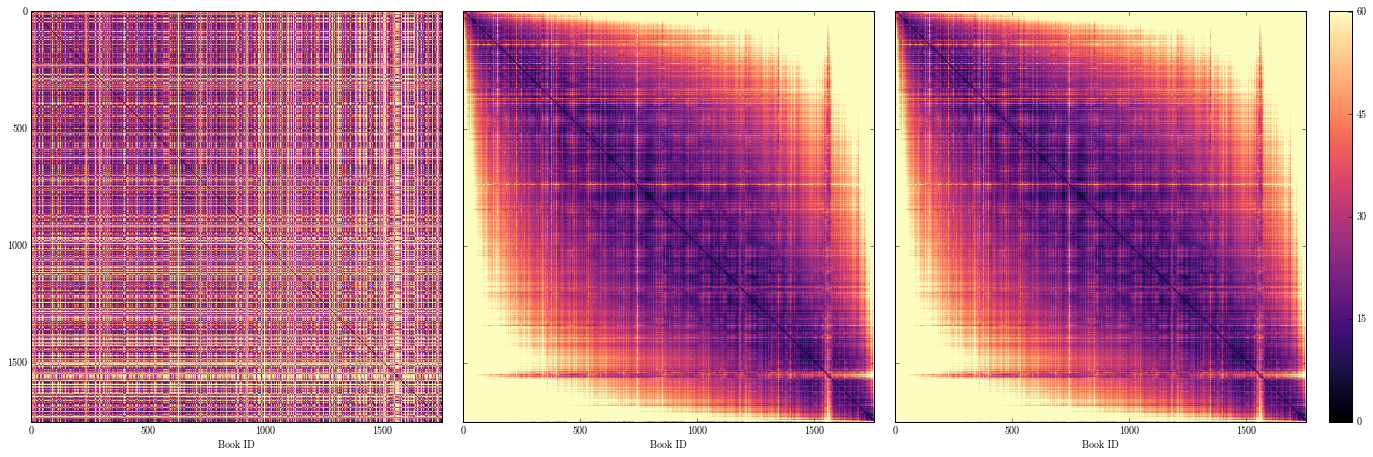

In [64]:
plotDistanceMatrix(allDistances,sortedDistances,cap=60)

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]


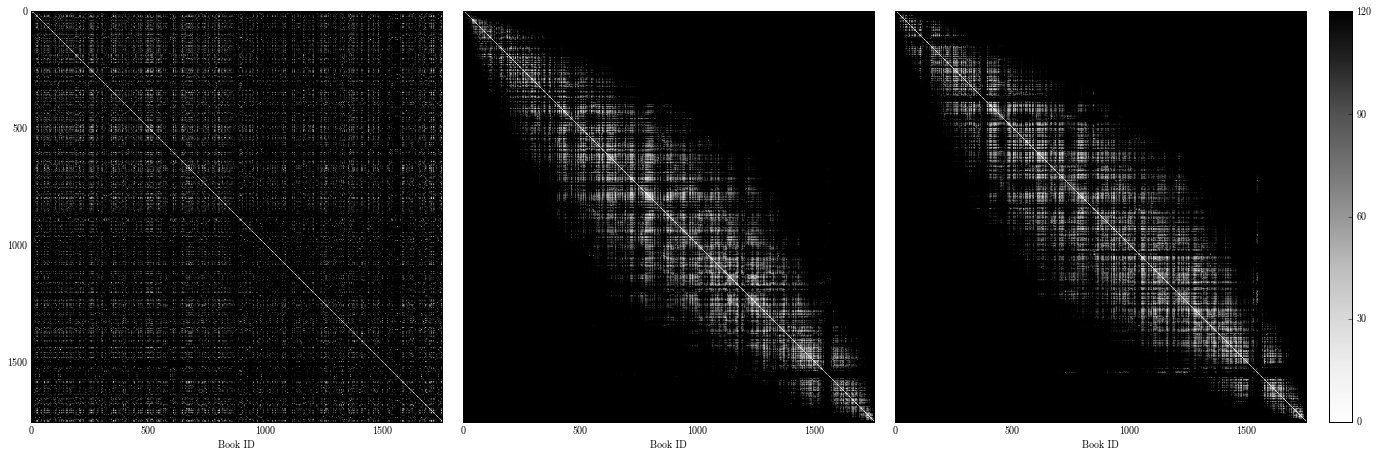

In [69]:
plotDistanceMatrix(allDistances,sortedDistances,cap=120,cmap="Greys")

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]


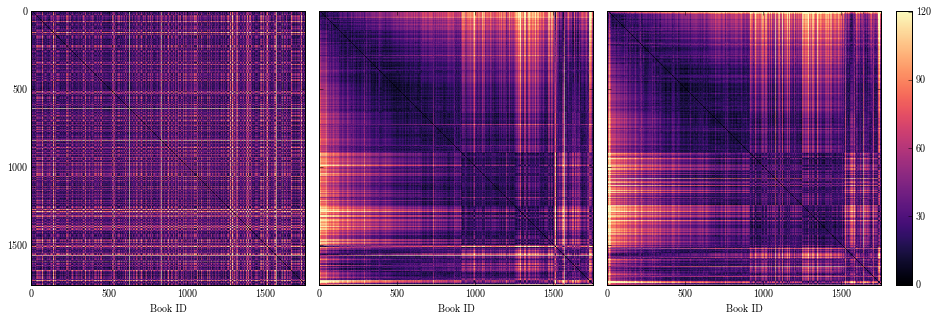

In [35]:
plotDistanceMatrix(allDistances,sortedDistances)

In [36]:
sortedDistances,cost = runSortingAlgorithm(allDistancesCenteredentered,niter=1000)

best swap: distance	node
           380.032	1045
best swap: distance	node
           265.485	530
best swap: distance	node
           226.034	808
best swap: distance	node
           163.291	730
best swap: distance	node
           166.068	1103
best swap: distance	node
           8.333	10
best swap: distance	node
           0.000	0
best swap: distance	node
           129.808	340
best swap: distance	node
           122.851	995
best swap: distance	node
           54.262	779
best swap: distance	node
           7.925	9
best swap: distance	node
           144.621	825
best swap: distance	node
           204.089	911
best swap: distance	node
           124.982	1575
best swap: distance	node
           198.938	909
best swap: distance	node
           121.877	873
best swap: distance	node
           93.107	878
best swap: distance	node
           134.145	1227
best swap: distance	node
           147.045	392
best swap: distance	node
           138.744	971
best swap: distance	node
           145.088	1563


[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]


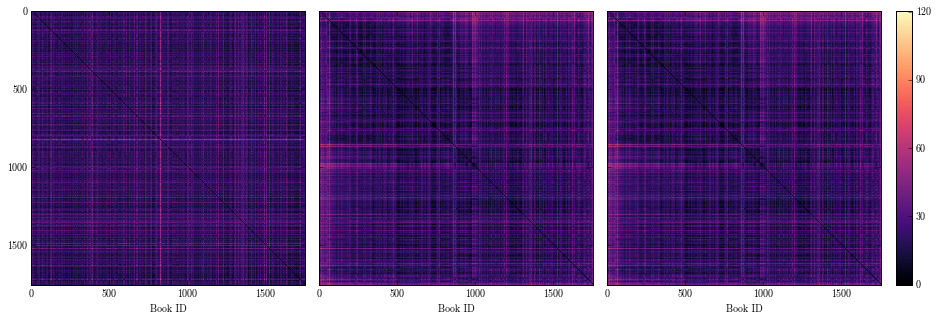

In [37]:
plotDistanceMatrix(allDistancesCentered,sortedDistances)

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]


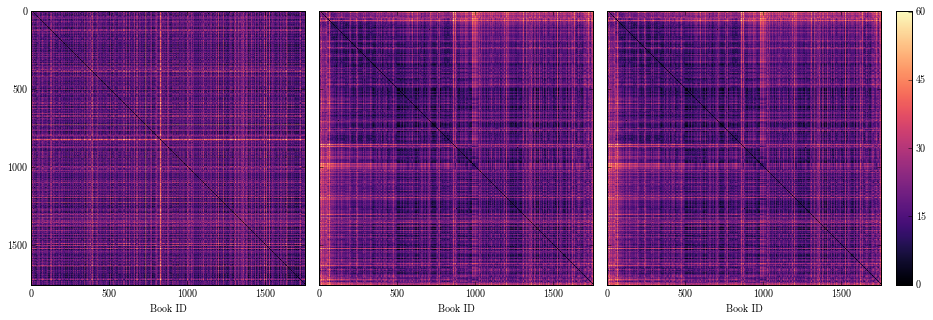

In [44]:
plotDistanceMatrix(allDistancesCentered,sortedDistances,cap=60)

[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]
[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]
[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]
[[   0    0    0 ...,    0    0    0]
 [   1    1    1 ...,    1    1    1]
 [   2    2    2 ...,    2    2    2]
 ..., 
 [1750 1750 1750 ..., 1750 1750 1750]
 [1751 1751 1751 ..., 1751 1751 1751]
 [1752 1752 1752 ..., 1752 1752 1752]]
[[   0    0    0 ...,    0    0    0]
 [   1    1    1 .

KeyboardInterrupt: 

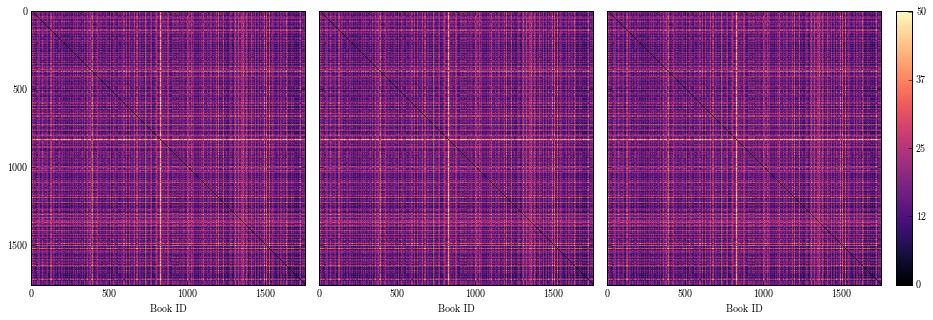

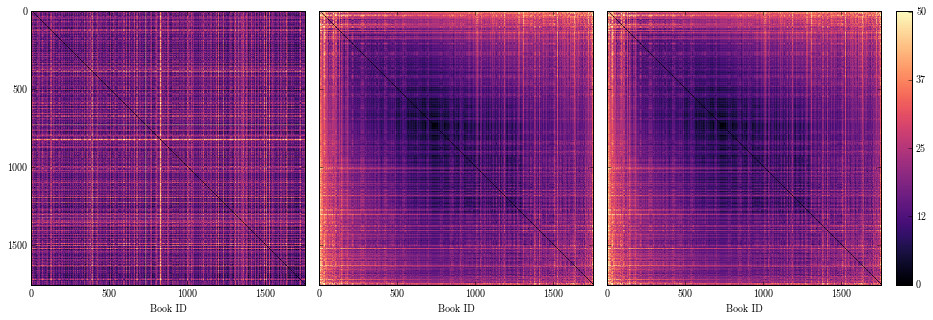

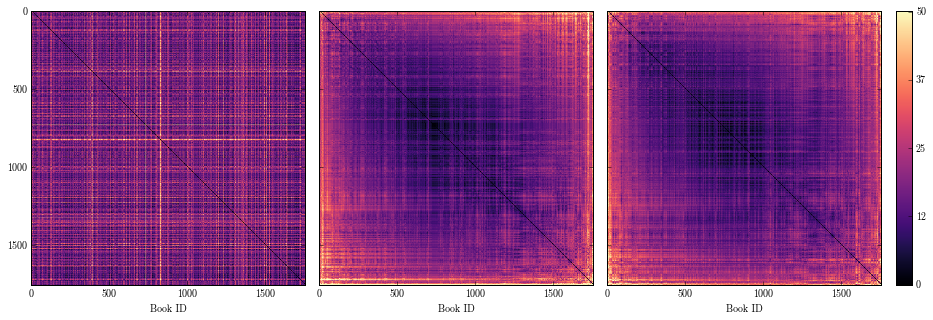

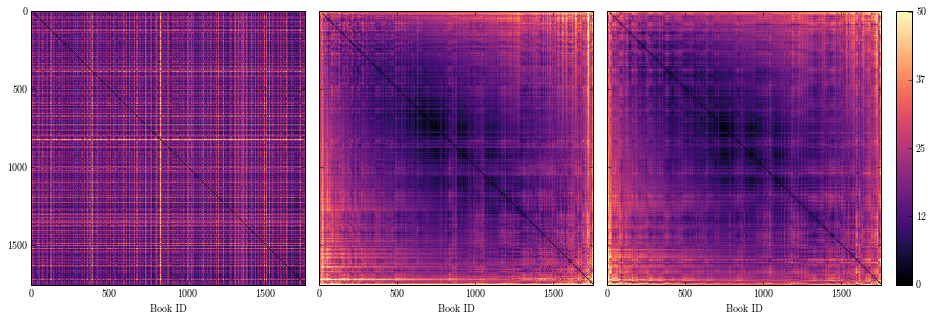

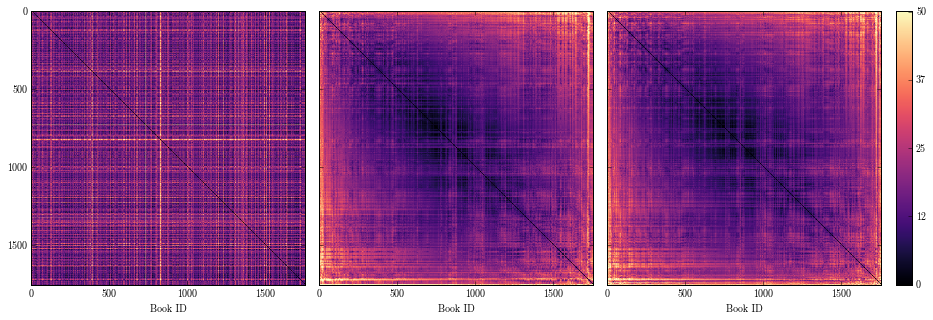

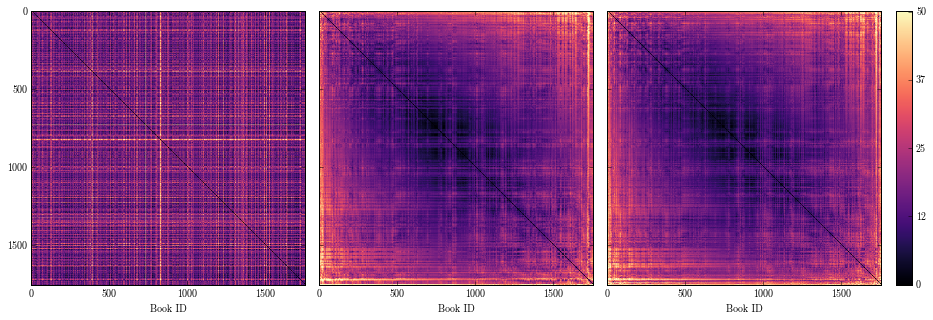

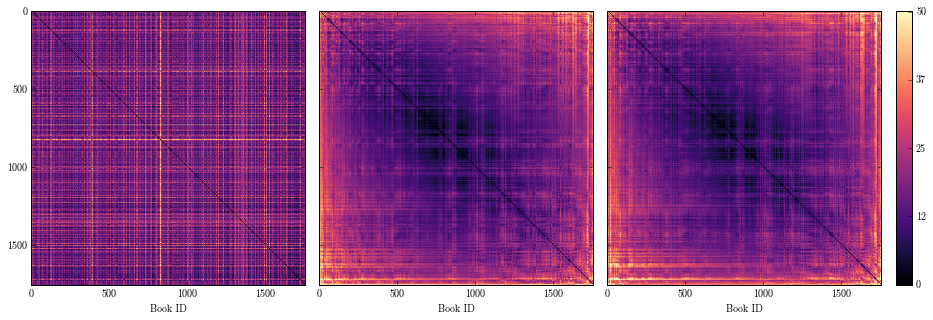

In [50]:
sortedDistances,cost = runSortingAlgorithm(allDistancesCentered,niter=10000,plot_every=1000,v=False)

In [73]:
np.random.shuffle?

In [80]:
a = list(range(10))

In [81]:
np.random.shuffle(a)

In [82]:
a

[7, 5, 8, 0, 1, 4, 9, 3, 6, 2]

In [79]:
np.ix_?

In [83]:
np.ix_(a,a)

(array([[7],
        [5],
        [8],
        [0],
        [1],
        [4],
        [9],
        [3],
        [6],
        [2]]), array([[7, 5, 8, 0, 1, 4, 9, 3, 6, 2]]))

In [85]:
b = np.random.rand(10,10)

In [88]:
b

array([[ 0.39548523,  0.60148205,  0.34712586,  0.26256127,  0.6842391 ,
         0.37022741,  0.27966717,  0.63501033,  0.76254325,  0.66652444],
       [ 0.90165121,  0.05647426,  0.00318702,  0.67591695,  0.44411024,
         0.92685525,  0.55229393,  0.26659283,  0.8286007 ,  0.04828592],
       [ 0.82910928,  0.17413462,  0.46773463,  0.15440281,  0.78842363,
         0.94715996,  0.60859695,  0.79961942,  0.64021366,  0.4840214 ],
       [ 0.75706281,  0.46842375,  0.77373812,  0.02894947,  0.4077804 ,
         0.69398229,  0.08625099,  0.74509693,  0.71232297,  0.34671352],
       [ 0.80745743,  0.67046852,  0.63451532,  0.49852813,  0.87545435,
         0.36201797,  0.11873269,  0.01827935,  0.66302668,  0.18019767],
       [ 0.30027139,  0.95584317,  0.63953787,  0.59330836,  0.08780179,
         0.30921332,  0.07019274,  0.70285232,  0.96334186,  0.56220442],
       [ 0.71928728,  0.77326392,  0.47894334,  0.54128414,  0.69903585,
         0.13534799,  0.85465927,  0.58386254

In [89]:
b = b[np.ix_(a,a)]

In [90]:
b

array([[ 0.3264323 ,  0.47755095,  0.46976316,  0.55215141,  0.0874279 ,
         0.70729987,  0.08049845,  0.13950371,  0.45832073,  0.37391357],
       [ 0.70285232,  0.30921332,  0.96334186,  0.30027139,  0.95584317,
         0.08780179,  0.56220442,  0.59330836,  0.07019274,  0.63953787],
       [ 0.54527945,  0.22815684,  0.17288389,  0.37750078,  0.18888823,
         0.78512198,  0.64558327,  0.32678746,  0.17697464,  0.90336882],
       [ 0.63501033,  0.37022741,  0.76254325,  0.39548523,  0.60148205,
         0.6842391 ,  0.66652444,  0.26256127,  0.27966717,  0.34712586],
       [ 0.26659283,  0.92685525,  0.8286007 ,  0.90165121,  0.05647426,
         0.44411024,  0.04828592,  0.67591695,  0.55229393,  0.00318702],
       [ 0.01827935,  0.36201797,  0.66302668,  0.80745743,  0.67046852,
         0.87545435,  0.18019767,  0.49852813,  0.11873269,  0.63451532],
       [ 0.02809393,  0.84954253,  0.62670854,  0.59390508,  0.41212749,
         0.35879356,  0.99686741,  0.28117302

In [91]:
a = [1,0,2,3,4,5,6,7,8,9]

In [92]:
b = np.random.rand(10,10)

In [93]:
b

array([[ 0.26163272,  0.3688272 ,  0.04779569,  0.43044591,  0.76982063,
         0.41817911,  0.61216592,  0.56727079,  0.81864864,  0.79061021],
       [ 0.00726436,  0.23683419,  0.77149211,  0.8943082 ,  0.51410047,
         0.07599689,  0.23670225,  0.21094455,  0.25296526,  0.2189794 ],
       [ 0.35341404,  0.76307141,  0.73825587,  0.51683612,  0.26894947,
         0.69111581,  0.41930265,  0.02556726,  0.65840835,  0.72101094],
       [ 0.3831317 ,  0.45597652,  0.7623586 ,  0.70819629,  0.19499542,
         0.35827383,  0.05660286,  0.06837095,  0.02912645,  0.94975695],
       [ 0.72277654,  0.00709497,  0.7489168 ,  0.37112457,  0.66463575,
         0.95842894,  0.02052494,  0.79211821,  0.39119893,  0.38436854],
       [ 0.74263889,  0.52873448,  0.30843042,  0.19480549,  0.38898993,
         0.49658362,  0.84918858,  0.23280051,  0.17091534,  0.15161021],
       [ 0.80314765,  0.98853195,  0.24598447,  0.209341  ,  0.97792266,
         0.7863009 ,  0.78910906,  0.13311113

In [94]:
b = b[np.ix_(a,a)]

In [95]:
b

array([[ 0.23683419,  0.00726436,  0.77149211,  0.8943082 ,  0.51410047,
         0.07599689,  0.23670225,  0.21094455,  0.25296526,  0.2189794 ],
       [ 0.3688272 ,  0.26163272,  0.04779569,  0.43044591,  0.76982063,
         0.41817911,  0.61216592,  0.56727079,  0.81864864,  0.79061021],
       [ 0.76307141,  0.35341404,  0.73825587,  0.51683612,  0.26894947,
         0.69111581,  0.41930265,  0.02556726,  0.65840835,  0.72101094],
       [ 0.45597652,  0.3831317 ,  0.7623586 ,  0.70819629,  0.19499542,
         0.35827383,  0.05660286,  0.06837095,  0.02912645,  0.94975695],
       [ 0.00709497,  0.72277654,  0.7489168 ,  0.37112457,  0.66463575,
         0.95842894,  0.02052494,  0.79211821,  0.39119893,  0.38436854],
       [ 0.52873448,  0.74263889,  0.30843042,  0.19480549,  0.38898993,
         0.49658362,  0.84918858,  0.23280051,  0.17091534,  0.15161021],
       [ 0.98853195,  0.80314765,  0.24598447,  0.209341  ,  0.97792266,
         0.7863009 ,  0.78910906,  0.13311113

In [97]:
np.max([0,1])

1